# GAN Hyperparameter Optimization using Grey Wolf Optimizer
This notebook implements a simple GAN for MNIST and optimizes its hyperparameters using the Grey Wolf Optimizer (GWO) algorithm.

**Optimized for low computation power - suitable for Google Colab**

In [1]:
import random
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

Using device: cuda


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 21.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 489kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.70MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.76MB/s]


In [3]:
# Generator

class Generator(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.z_dim = z_dim
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Linear(1024, 28 * 28),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.net(z)
        return out.view(-1, 1, 28, 28)

# Discriminator

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.feat = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.classifier = nn.Sequential(
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        f = self.feat(x)
        out = self.classifier(f)
        return out, f

def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)

In [4]:
bce = nn.BCELoss()

def train_gan_one_epoch(generator, discriminator, opt_g, opt_d, dataloader, z_dim):
    generator.train(); discriminator.train()
    running_d_loss = 0.0
    running_g_loss = 0.0
    n_samples = 0
    for real_imgs, _ in dataloader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)
        n_samples += batch_size

        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # Train discriminator
        opt_d.zero_grad()
        outputs_real, _ = discriminator(real_imgs)
        d_loss_real = bce(outputs_real, real_labels)

        z = torch.randn(batch_size, z_dim, device=device)
        fake_imgs = generator(z)
        outputs_fake, _ = discriminator(fake_imgs.detach())
        d_loss_fake = bce(outputs_fake, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        opt_d.step()

        # Train generator
        opt_g.zero_grad()
        outputs_fake_for_g, _ = discriminator(fake_imgs)
        g_loss = bce(outputs_fake_for_g, real_labels)
        g_loss.backward()
        opt_g.step()

        running_d_loss += d_loss.item() * batch_size
        running_g_loss += g_loss.item() * batch_size

    avg_d = running_d_loss / n_samples
    avg_g = running_g_loss / n_samples
    return avg_d, avg_g

def evaluate_on_loader(generator, discriminator, loader, z_dim):
    """Evaluate d_loss + g_loss on loader (no parameter updates). Lower is better."""
    generator.eval(); discriminator.eval()
    total_d = 0.0
    total_g = 0.0
    n = 0
    with torch.no_grad():
        for real_imgs, _ in loader:
            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)
            n += batch_size

            # discriminator real
            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)

            outputs_real, _ = discriminator(real_imgs)
            d_loss_real = bce(outputs_real, real_labels)

            z = torch.randn(batch_size, z_dim, device=device)
            fake_imgs = generator(z)
            outputs_fake, _ = discriminator(fake_imgs)
            d_loss_fake = bce(outputs_fake, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            outputs_fake_for_g, _ = discriminator(fake_imgs)
            g_loss = bce(outputs_fake_for_g, real_labels)

            total_d += d_loss.item() * batch_size
            total_g += g_loss.item() * batch_size

    if n == 0:
        return float('inf')
    return (total_d + total_g) / n  # combined metric

def clamp_hyperparams(pos, bounds):
    """pos: np.array [lr_g, lr_d, z_dim, batch_size]; bounds: list of (min,max)"""
    clamped = np.clip(pos, [b[0] for b in bounds], [b[1] for b in bounds])
    lr_g = float(clamped[0])
    lr_d = float(clamped[1])
    z_dim = int(round(clamped[2]))
    batch_size = int(round(clamped[3]))
    z_dim = max(8, z_dim)
    batch_size = max(4, batch_size)
    return lr_g, lr_d, z_dim, batch_size

In [5]:
# Grey Wolf Optimizer

def grey_wolf_optimizer(population_size,
                        max_iterations,
                        bounds,
                        dataset,
                        eval_epochs=1,
                        eval_subset_size=2048,
                        device=device):
    D = len(bounds)
    # initialize population in bounds
    population = np.zeros((population_size, D))
    for d in range(D):
        population[:, d] = np.random.uniform(bounds[d][0], bounds[d][1], population_size)

    alpha_pos = None; beta_pos = None; delta_pos = None
    alpha_score = float('inf'); beta_score = float('inf'); delta_score = float('inf')

    # evaluation subset (fixed for speed)
    subset_indices = np.random.choice(len(dataset), size=min(eval_subset_size, len(dataset)), replace=False)
    subset = Subset(dataset, subset_indices)

    a_start = 2.0
    for it in range(max_iterations):
        a = a_start * (1 - it / float(max_iterations))
        print(f"\n--- GWO iteration {it+1}/{max_iterations} (a={a:.3f}) ---")

        # evaluate wolves
        scores = []
        for w in range(population_size):
            pos = population[w]
            lr_g, lr_d, z_dim, batch_size = clamp_hyperparams(pos, bounds)
            print(f"Wolf {w+1}: lr_g={lr_g:.6g}, lr_d={lr_d:.6g}, z_dim={z_dim}, batch_size={batch_size}")

            # build models & optimizers for this wolf
            gen = Generator(z_dim).to(device); gen.apply(weights_init)
            disc = Discriminator().to(device); disc.apply(weights_init)
            opt_g = optim.Adam(gen.parameters(), lr=lr_g, betas=(0.5, 0.999))
            opt_d = optim.Adam(disc.parameters(), lr=lr_d, betas=(0.5, 0.999))

            loader = DataLoader(subset, batch_size=batch_size, shuffle=True, drop_last=True)

            # short training (eval_epochs)
            for e in range(eval_epochs):
                d_loss, g_loss = train_gan_one_epoch(gen, disc, opt_g, opt_d, loader, z_dim)
                print(f"  eval epoch {e+1}/{eval_epochs} - d_loss: {d_loss:.4f}, g_loss: {g_loss:.4f}")

            # evaluate combined loss on same loader (no further training)
            fitness = evaluate_on_loader(gen, disc, loader, z_dim)
            print(f"  fitness (d+g avg): {fitness:.6f}")

            scores.append(fitness)

            # update alpha/beta/delta
            if fitness < alpha_score:
                alpha_score = fitness
                alpha_pos = pos.copy()
                print("   -> new alpha")
            elif fitness < beta_score:
                beta_score = fitness
                beta_pos = pos.copy()
                print("   -> new beta")
            elif fitness < delta_score:
                delta_score = fitness
                delta_pos = pos.copy()
                print("   -> new delta")

        # update positions
        for w in range(population_size):
            X = population[w].copy()
            # compute A and C for alpha/beta/delta
            r1 = np.random.rand(D); r2 = np.random.rand(D)
            A1 = 2 * a * r1 - a; C1 = 2 * r2
            r1 = np.random.rand(D); r2 = np.random.rand(D)
            A2 = 2 * a * r1 - a; C2 = 2 * r2
            r1 = np.random.rand(D); r2 = np.random.rand(D)
            A3 = 2 * a * r1 - a; C3 = 2 * r2

            # fallback if not found yet
            if alpha_pos is None: alpha_pos = X.copy()
            if beta_pos is None:  beta_pos = X.copy()
            if delta_pos is None: delta_pos = X.copy()

            D_alpha = np.abs(C1 * alpha_pos - X)
            D_beta  = np.abs(C2 * beta_pos  - X)
            D_delta = np.abs(C3 * delta_pos - X)

            X1 = alpha_pos - A1 * D_alpha
            X2 = beta_pos  - A2 * D_beta
            X3 = delta_pos - A3 * D_delta

            newX = (X1 + X2 + X3) / 3.0

            # clip to bounds
            for d in range(D):
                newX[d] = np.clip(newX[d], bounds[d][0], bounds[d][1])

            population[w] = newX

        print(f"Iteration {it+1} best scores: alpha={alpha_score:.6f}, beta={beta_score:.6f}, delta={delta_score:.6f}")

    best_lr_g, best_lr_d, best_z_dim, best_batch_size = clamp_hyperparams(alpha_pos, bounds)
    best = {'lr_g': best_lr_g, 'lr_d': best_lr_d, 'z_dim': best_z_dim, 'batch_size': best_batch_size, 'score': alpha_score}
    return best


Starting GWO search (FAST MODE)...

--- GWO iteration 1/3 (a=2.000) ---
Wolf 1: lr_g=0.000380795, lr_d=0.000164458, z_dim=140, batch_size=109
  eval epoch 1/1 - d_loss: 1.3446, g_loss: 0.5989
  fitness (d+g avg): 1.962561
   -> new alpha
Wolf 2: lr_g=0.000951207, lr_d=0.000164435, z_dim=156, batch_size=40
  eval epoch 1/1 - d_loss: 1.2550, g_loss: 0.7265
  fitness (d+g avg): 1.855789
   -> new alpha
Wolf 3: lr_g=0.000734674, lr_d=6.75028e-05, z_dim=53, batch_size=36
  eval epoch 1/1 - d_loss: 1.3845, g_loss: 0.5861
  fitness (d+g avg): 1.880499
   -> new beta
Wolf 4: lr_g=0.000602672, lr_d=0.000867514, z_dim=195, batch_size=37
  eval epoch 1/1 - d_loss: 1.0999, g_loss: 1.6610
  fitness (d+g avg): 2.399206
   -> new delta
Iteration 1 best scores: alpha=1.855789, beta=1.880499, delta=2.399206

--- GWO iteration 2/3 (a=1.333) ---
Wolf 1: lr_g=0.00083252, lr_d=0.000256817, z_dim=50, batch_size=16
  eval epoch 1/1 - d_loss: 1.2629, g_loss: 0.8107
  fitness (d+g avg): 2.120109
   -> new del

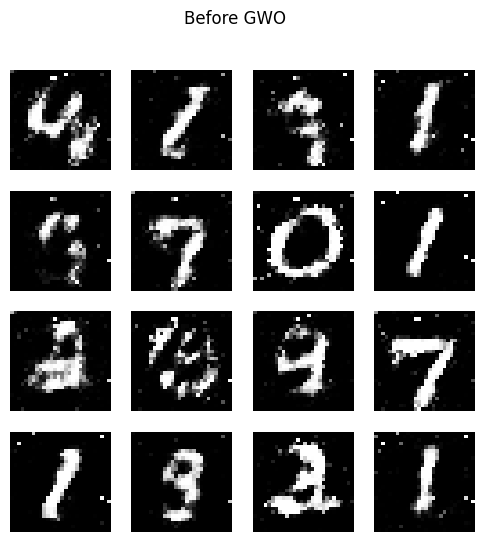


Generated images AFTER optimization:


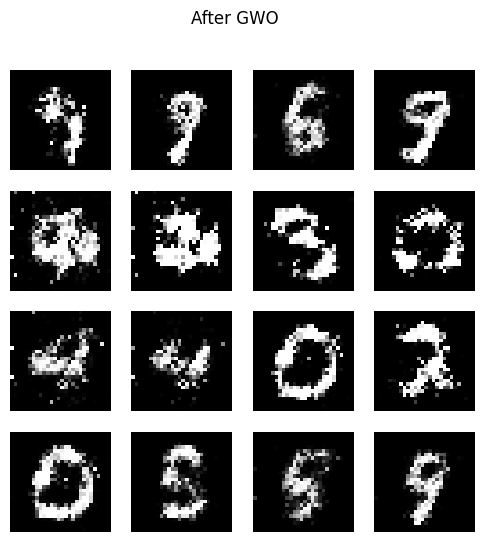


Loss comparison (numbers of epochs may differ):


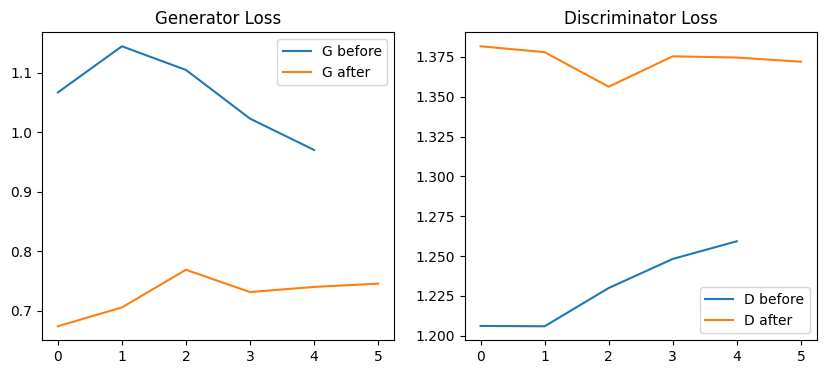


Finished. Inspect generated images, printed losses, and best hyperparameters above.


In [6]:
def train_final_and_return(generator, discriminator, lr_g, lr_d, z_dim, batch_size, dataset, epochs=5):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    gen = generator.to(device); disc = discriminator.to(device)
    gen.apply(weights_init); disc.apply(weights_init)
    opt_g = optim.Adam(gen.parameters(), lr=lr_g, betas=(0.5,0.999))
    opt_d = optim.Adam(disc.parameters(), lr=lr_d, betas=(0.5,0.999))

    g_losses = []; d_losses = []
    fixed_noise = torch.randn(16, z_dim, device=device)
    for ep in range(epochs):
        d_loss, g_loss = train_gan_one_epoch(gen, disc, opt_g, opt_d, loader, z_dim)
        g_losses.append(g_loss); d_losses.append(d_loss)
        print(f"[Final Train] epoch {ep+1}/{epochs} - d_loss: {d_loss:.4f}, g_loss: {g_loss:.4f}")

    return gen, disc, g_losses, d_losses, fixed_noise

def plot_samples(generator, fixed_noise, title="Samples"):
    generator.eval()
    with torch.no_grad():
        imgs = generator(fixed_noise).cpu()
    imgs = (imgs + 1.0) / 2.0  # tanh -> [0,1]
    fig, axes = plt.subplots(4,4, figsize=(6,6))
    for i, ax in enumerate(axes.flatten()):
        ax.axis('off')
        ax.imshow(imgs[i].squeeze(0), cmap='gray')
    fig.suptitle(title)
    plt.show()

def plot_losses(g_before, d_before, g_after, d_after):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(g_before, label='G before')
    plt.plot(g_after, label='G after')
    plt.legend(); plt.title('Generator Loss')

    plt.subplot(1,2,2)
    plt.plot(d_before, label='D before')
    plt.plot(d_after, label='D after')
    plt.legend(); plt.title('Discriminator Loss')
    plt.show()

bounds = [
    (1e-5, 1e-3),  # lr_g
    (1e-5, 1e-3),  # lr_d
    (50, 200),     # z_dim
    (16, 128)      # batch_size
]

population_size = 4
max_iterations = 3
eval_epochs = 1
eval_subset_size = 2048

print("\nStarting GWO search (FAST MODE)...")
best = grey_wolf_optimizer(population_size=population_size,
                           max_iterations=max_iterations,
                           bounds=bounds,
                           dataset=trainset,
                           eval_epochs=eval_epochs,
                           eval_subset_size=eval_subset_size,
                           device=device)

print("\nBest hyperparameters found by GWO (FAST MODE):")
print(best)

print("\nTraining baseline GAN (before GWO)...")
baseline = {'lr_g': 0.0002, 'lr_d': 0.0002, 'z_dim': 100, 'batch_size': 64}
gen_b, disc_b, g_losses_b, d_losses_b, fixed_noise_b = train_final_and_return(
    Generator(baseline['z_dim']),
    Discriminator(),
    baseline['lr_g'],
    baseline['lr_d'],
    baseline['z_dim'],
    baseline['batch_size'],
    trainset,
    epochs=5
)

print("\nTraining final GAN (after GWO)...")
gen_a, disc_a, g_losses_a, d_losses_a, fixed_noise_a = train_final_and_return(
    Generator(best['z_dim']),
    Discriminator(),
    best['lr_g'],
    best['lr_d'],
    best['z_dim'],
    best['batch_size'],
    trainset,
    epochs=6
)

print("\nGenerated images BEFORE optimization:")
plot_samples(gen_b, fixed_noise_b, title="Before GWO")

print("\nGenerated images AFTER optimization:")
plot_samples(gen_a, fixed_noise_a, title="After GWO")

print("\nLoss comparison (numbers of epochs may differ):")
try:
    plot_losses(g_losses_b, d_losses_b, g_losses_a, d_losses_a)
except Exception as e:
    print("Could not plot losses:", e)

print("\nFinished. Inspect generated images, printed losses, and best hyperparameters above.")